In [ ]:
import wandb

# finetune -> 9vh2qqg0
# scratch -> rzpn3bhn 

api = wandb.Api()
sweep = api.sweep("23f2001173-indian-institute-of-technology-madras/garbage_clf-src_scripts/rzpn3bhn")

best_run = sweep.best_run()
print(f"Best run: {best_run.name}")
print(f"Best val_accuracy: {best_run.summary.get('val_accuracy')}")
print("\nBest hyperparameters:")
for key, value in best_run.config.items():
    if not key.startswith('_'):
        print(f"  {key}: {value}")

wandb: Sorting runs by -summary_metrics.val_accuracy


Best run: expert-sweep-2
Best val_accuracy: 0.8004434704780579

Best hyperparameters:
  lr: 0.0001279627961349995
  stride: 1
  dropout: 0.2
  padding: same
  data_dir: data
  img_size: 128
  strategy: same
  num_dense: 128
  pooling_k: 2
  batch_size: 16
  input_size: 128
  max_epochs: 20
  num_layers: 5
  filter_size: 5
  in_channels: 3
  num_classes: 6
  num_workers: 4
  base_features: 64
  conv_activation: mish
  dense_activation: relu
  use_augmentation: False
  include_batchnorm: True


In [2]:
for k, v in best_run.summary.items():
    if not k.startswith('_'):
        print(f"{k}: {v}")

epoch: 19
train_accuracy: 0.9598239064216614
train_f1_class_cardboard: 0.9725086092948914
train_f1_class_glass: 0.9514563083648682
train_f1_class_metal: 0.9423728585243224
train_f1_class_paper: 0.9799764156341552
train_f1_class_plastic: 0.952654242515564
train_f1_class_trash: 0.9435897469520568
train_loss_epoch: 0.13386356830596924
train_loss_step: 0.12845806777477264
train_precision_class_cardboard: 0.9691780805587769
train_precision_class_glass: 0.950138509273529
train_precision_class_metal: 0.9423728585243224
train_precision_class_paper: 0.9857819676399232
train_precision_class_plastic: 0.9485714435577391
train_precision_class_trash: 0.9484536051750184
train_recall_class_cardboard: 0.9758620858192444
train_recall_class_glass: 0.9527778029441832
train_recall_class_metal: 0.9423728585243224
train_recall_class_paper: 0.9742388725280762
train_recall_class_plastic: 0.9567723274230956
train_recall_class_trash: 0.9387755393981934
trainer/global_step: 2279
val_accuracy: 0.8004434704780579
v

In [ ]:
import pandas as pd
import wandb

runs_df = pd.read_csv("wandb_export_scratch.csv")

corr = runs_df[
    ["val_accuracy", "lr", "dropout", "base_features", "num_dense",
     "dropout"]
].corr()["val_accuracy"]

print("=== Correlation with Validation Accuracy ===")
print(corr)

val_accuracy     1.000000
lr              -0.486674
dropout         -0.442366
base_features    0.368688
num_dense        0.174427
dropout         -0.442366
Name: val_accuracy, dtype: float64


In [7]:
_config = best_run.config
class Config:
    def __init__(self, cfg):
        for k, v in cfg.items():
            setattr(self, k, v)

config = Config(_config)

In [8]:
import sys
from pathlib import Path

# Get project root from notebook location
PROJECT_ROOT = Path.cwd().parent if Path.cwd().name == 'notebooks' else Path.cwd()
sys.path.insert(0, str(PROJECT_ROOT))
print(f"Added to path: {PROJECT_ROOT}")

Added to path: /home/nevrohelios/project/garbage_clf


In [9]:
import wandb
import os
import pytorch_lightning as pl
from pathlib import Path

from src.models.simple_cnn import SimpleCNN
from src.lightning.model import ModelLightning
from src.data.module import DataLoaderWrapper

dm = DataLoaderWrapper(
    data_dir=Path(os.path.join('..', config.data_dir)),
    img_size=config.img_size,
    mode='augment' if config.use_augmentation else None,
    batch_size=config.batch_size,
    num_workers=config.num_workers,
)

model = SimpleCNN(
    num_layers=config.num_layers,
    filter_size=config.filter_size,
    num_dense=config.num_dense,
    conv_activation=config.conv_activation,
    num_classes=config.num_classes,
    dense_activation=config.dense_activation,
    in_channels=config.in_channels,
    stride=config.stride,
    input_size=config.input_size,
    padding=config.padding,
    dropout=config.dropout if config.dropout > 0 else None,
    strategy=config.strategy,
    include_batchnorm=config.include_batchnorm,
    pooling_k=config.pooling_k,
    base_features=config.base_features,
)

pl_model = ModelLightning(
    model=model,
    lr=config.lr,
    idx_to_class=dm.idx_to_class,
)

In [10]:
# trainer = pl.Trainer(
#         max_epochs=config.max_epochs,
#         # logger=logger,
#         accelerator='auto',
#         devices='auto',
#         log_every_n_steps=10,
#     )

# trainer.fit(pl_model, datamodule=dm)

pl_model = ModelLightning.load_from_checkpoint(
    '/home/nevrohelios/project/garbage_clf/checkpoints/best_model_epoch=12_val_accuracy=0.8049.ckpt',
    model=model,
    idx_to_class=dm.idx_to_class
)

test_dataset = dm.test_dataloader()

In [11]:
trainer = pl.Trainer(
        max_epochs=config.max_epochs,
        # logger=logger,
        accelerator='auto',
        devices='auto',
        log_every_n_steps=10,
    )

trainer.test(model=pl_model, datamodule=dm)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/nevrohelios/miniconda3/envs/flsplit/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
/home/nevrohelios/miniconda3/envs/flsplit/lib/python3.10/site-packages/torch/__init__.py:1551: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allo

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃          Test metric           ┃          DataLoader 0          ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_accuracy          │       0.8545816540718079       │
│    test_f1_class_cardboard     │       0.9192546606063843       │
│      test_f1_class_glass       │       0.8380952477455139       │
│      test_f1_class_metal       │       0.7837837934494019       │
│      test_f1_class_paper       │       0.9257642030715942       │
│     test_f1_class_plastic      │       0.8258706331253052       │
│      test_f1_class_trash       │       0.7272727489471436       │
│           test_loss            │       0.4093344807624817       │
│ test_precision_class_cardboard │       0.9135802388191223       │
│   test_precision_class_glass   │       0.778761088848114        │
│   test_precision_class_metal   │       0.8529411554336548       │
│   test_precision_class_paper   │       0.9724770784378052       │
│  test_precision_class_plastic  │       0.7904762029647827       │
│   test_precision_class_trash   │       0.7692307829856873       │
│  test_recall_class_cardboard   │       0.925000011920929        │
│    test_recall_class_glass     │       0.907216489315033        │
│    test_recall_class_metal     │       0.7250000238418579       │
│    test_recall_class_paper     │       0.8833333253860474       │
│   test_recall_class_plastic    │       0.8645833134651184       │
│    test_recall_class_trash     │       0.6896551847457886       │
└────────────────────────────────┴────────────────────────────────┘

[{'test_loss': 0.4093344807624817,
  'test_accuracy': 0.8545816540718079,
  'test_f1_class_cardboard': 0.9192546606063843,
  'test_recall_class_cardboard': 0.925000011920929,
  'test_precision_class_cardboard': 0.9135802388191223,
  'test_f1_class_glass': 0.8380952477455139,
  'test_recall_class_glass': 0.907216489315033,
  'test_precision_class_glass': 0.778761088848114,
  'test_f1_class_metal': 0.7837837934494019,
  'test_recall_class_metal': 0.7250000238418579,
  'test_precision_class_metal': 0.8529411554336548,
  'test_f1_class_paper': 0.9257642030715942,
  'test_recall_class_paper': 0.8833333253860474,
  'test_precision_class_paper': 0.9724770784378052,
  'test_f1_class_plastic': 0.8258706331253052,
  'test_recall_class_plastic': 0.8645833134651184,
  'test_precision_class_plastic': 0.7904762029647827,
  'test_f1_class_trash': 0.7272727489471436,
  'test_recall_class_trash': 0.6896551847457886,
  'test_precision_class_trash': 0.7692307829856873}]

In [12]:
import torchinfo

torchinfo.summary(pl_model, (32, 3, 128, 128))

Layer (type:depth-idx)                   Output Shape              Param #
ModelLightning                           [32, 6]                   --
├─SimpleCNN: 1-1                         [32, 6]                   --
│    └─Sequential: 2-1                   [32, 6]                   --
│    │    └─Sequential: 3-1              [32, 64, 64, 64]          4,992
│    │    └─Sequential: 3-2              [32, 64, 32, 32]          102,592
│    │    └─Sequential: 3-3              [32, 64, 16, 16]          102,592
│    │    └─Sequential: 3-4              [32, 64, 8, 8]            102,592
│    │    └─Sequential: 3-5              [32, 64, 4, 4]            102,592
│    │    └─Flatten: 3-6                 [32, 1024]                --
│    │    └─Sequential: 3-7              [32, 128]                 131,200
│    │    └─Sequential: 3-8              [32, 6]                   774
Total params: 547,334
Trainable params: 547,334
Non-trainable params: 0
Total mult-adds (G): 20.39
Input size (MB): 6.29
Forwa

In [13]:
import random
import torch
d = test_dataset.dataset
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

sample_idxs = random.sample(range(len(d)), 30)
samples = torch.stack([d[i][0] for i in sample_idxs])
labels = torch.tensor([d[i][1] for i in sample_idxs])
outputs = pl_model.forward(samples.to(device))
preds = torch.argmax(outputs, 1).cpu()

In [19]:
from matplotlib import pyplot as plt
import numpy as np

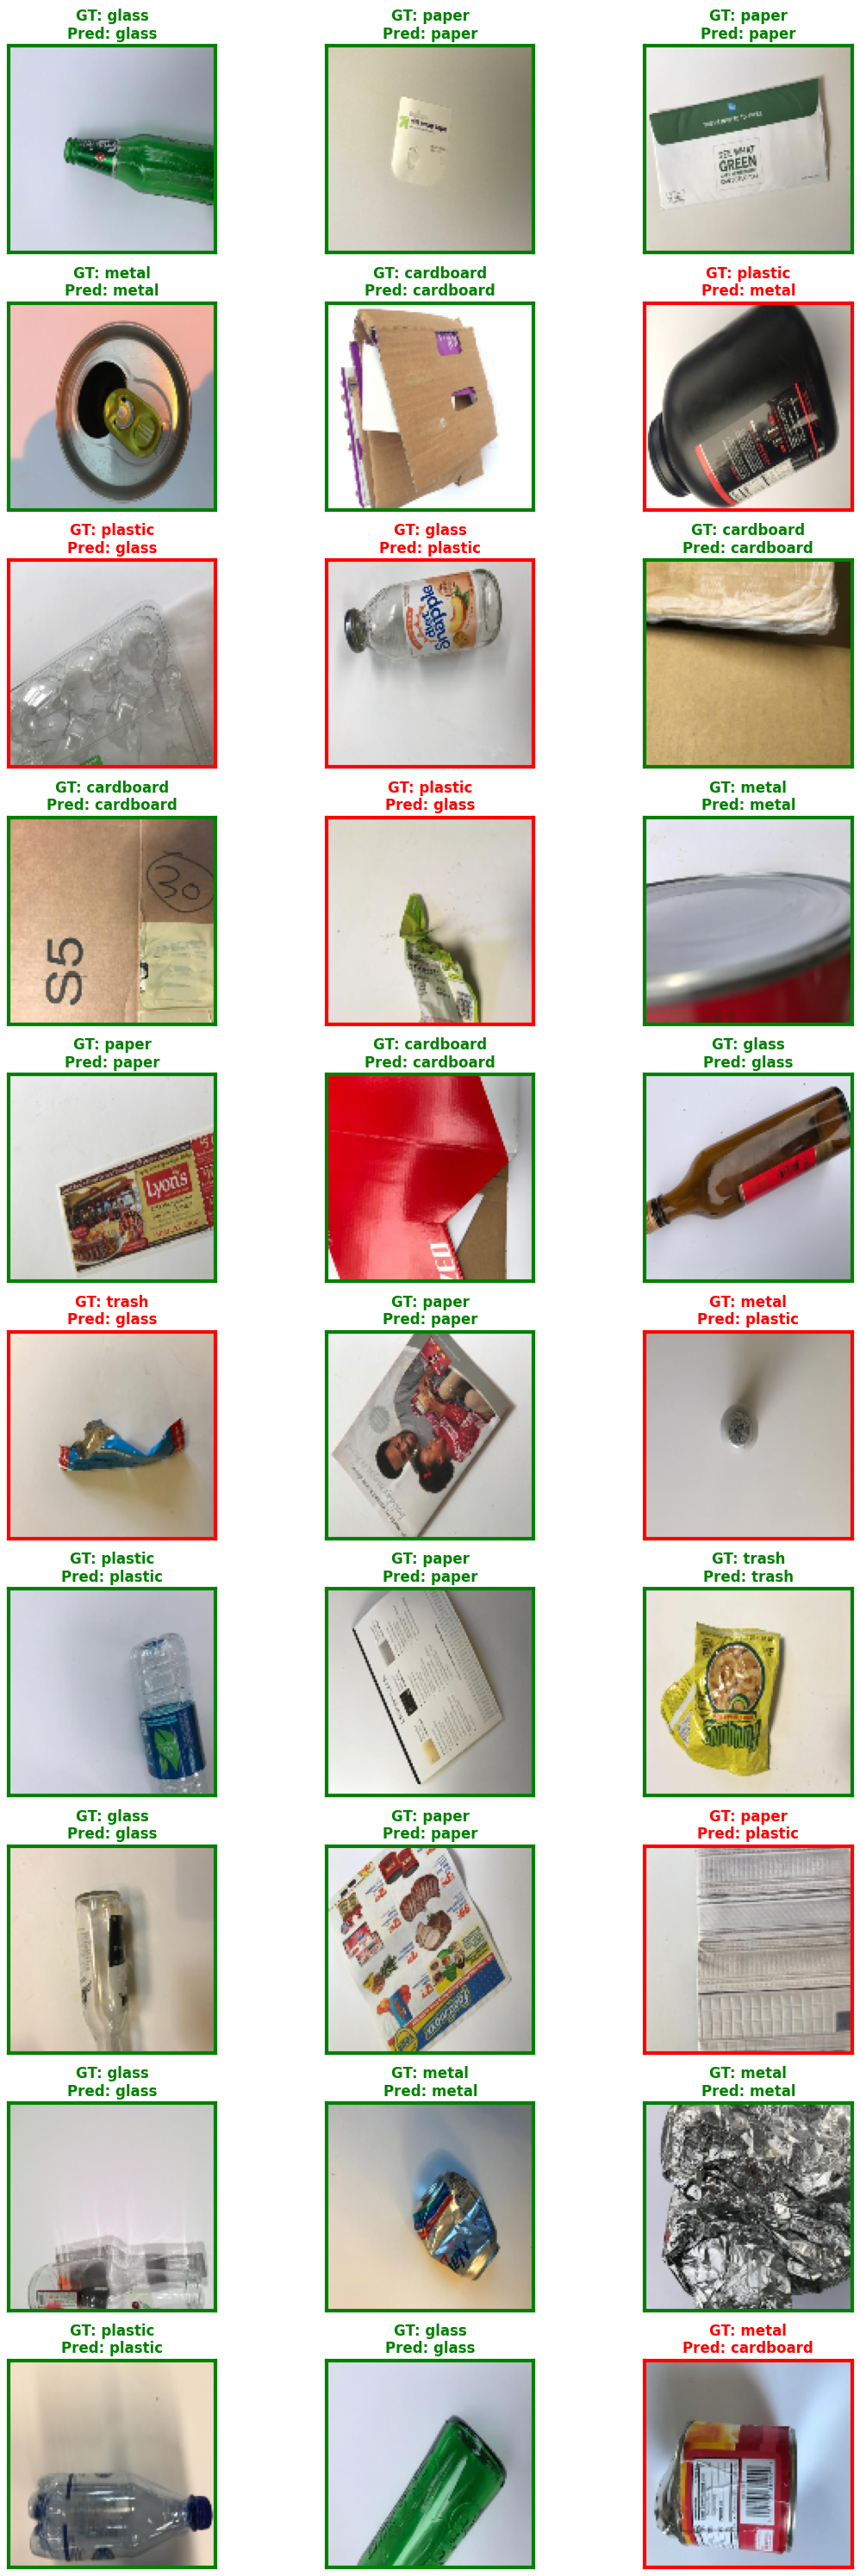

In [28]:
import numpy as np
import matplotlib.pyplot as plt

# ImageNet stats
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

# Create 10x3 grid
fig, axs = plt.subplots(nrows=10, ncols=3, figsize=(12, 30))
axs = axs.ravel()

for i, ax in enumerate(axs):
    if i >= len(samples):
        ax.axis('off')
        continue

    img = samples[i].cpu()

    # CHW -> HWC
    if img.shape[0] == 3:
        img = img.permute(1, 2, 0)

    img = img.numpy()

    # Unnormalize
    img = img * std + mean
    img = np.clip(img, 0, 1)

    ax.imshow(img)

    # Style
    ax.set_xticks([])
    ax.set_yticks([])

    gt = dm.idx_to_class[labels[i].item()]
    pred = dm.idx_to_class[preds[i].item()]

    is_correct = (gt == pred)
    color = "green" if is_correct else "red"

    # Colored border
    for spine in ax.spines.values():
        spine.set_edgecolor(color)
        spine.set_linewidth(3)

    ax.set_title(
        f"GT: {gt}\nPred: {pred}",
        fontsize=12,
        color=color,
        fontweight="bold"
    )

plt.tight_layout()
plt.show()

In [18]:
fig.savefig("test_predictions_grid.png", dpi=300, bbox_inches="tight")

In [147]:
model.eval()
first_conv = model.model[0]
first_conv

Sequential(
  (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (1): Mish()
  (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Dropout(p=0.2, inplace=False)
)

In [148]:
x, y = d[7]
x.shape, y

(torch.Size([3, 128, 128]), 0)

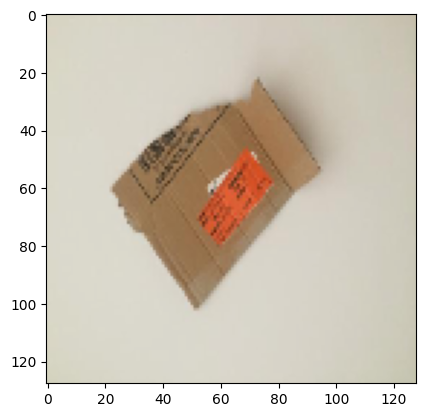

In [149]:
plt.imshow(x.permute(1, 2, 0)*std + mean)
plt.show();

In [152]:

with torch.no_grad():
    img_batch = x.unsqueeze(0).to(next(model.parameters()).device)
    feature_maps = first_conv(img_batch)

feature_maps.shape

torch.Size([1, 64, 64, 64])

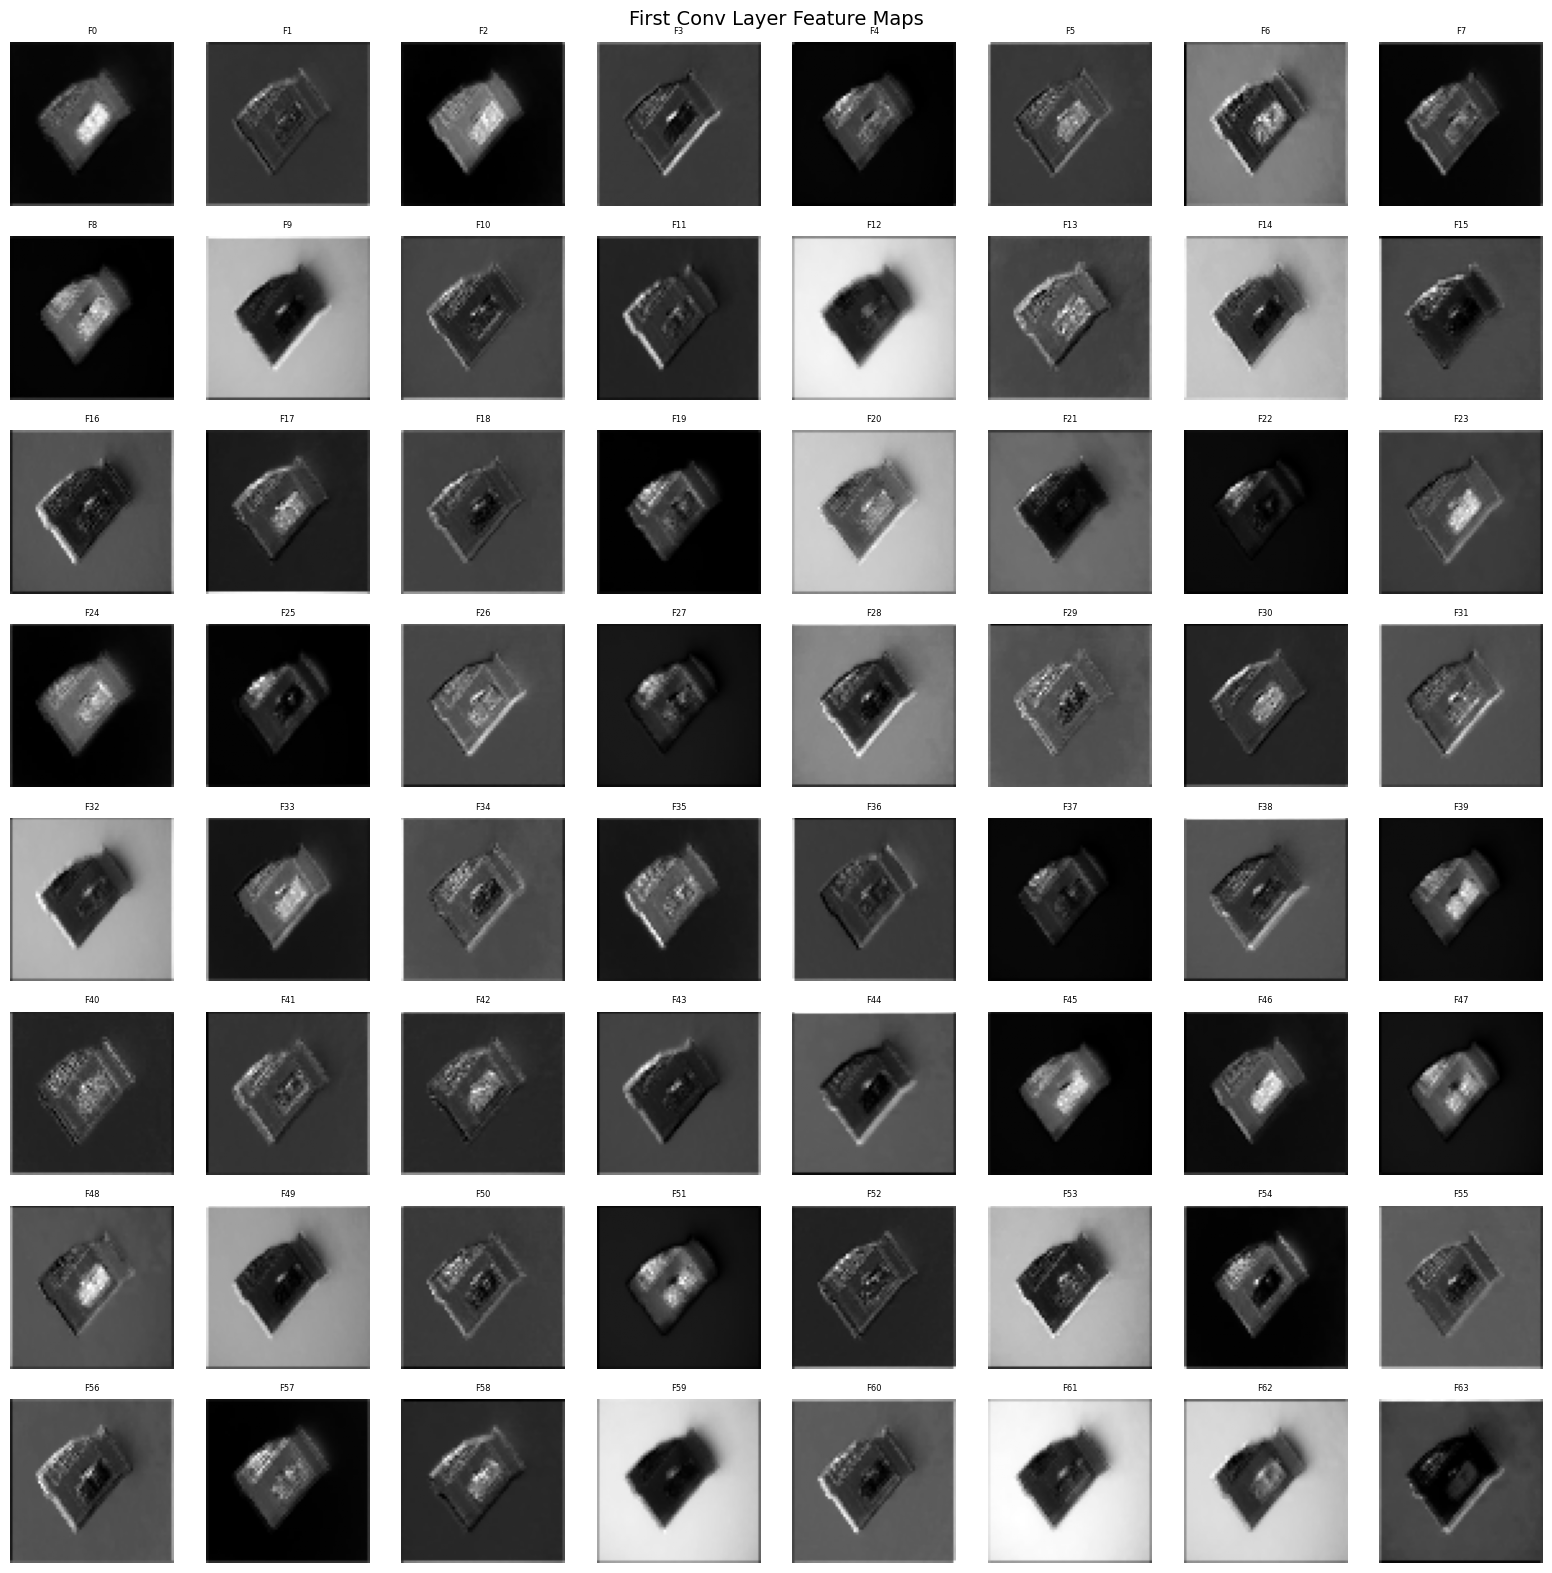

In [155]:
import math

feature_maps = feature_maps.squeeze(0)
num_filters = feature_maps.shape[0]
cols = 8
rows = math.ceil(num_filters / cols)

plt.figure(figsize=(cols * 2, rows * 2))

for i in range(num_filters):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(feature_maps[i].cpu(), cmap="gray")
    plt.axis("off")
    plt.title(f"F{i}", fontsize=6)

plt.suptitle("First Conv Layer Feature Maps", fontsize=14)
plt.tight_layout()
plt.savefig("first conv layer feat maps")
plt.tight_layout()

In [88]:
# rd_conv = model.model[:5]

# with torch.no_grad():
#     img_batch = x.unsqueeze(0).to(next(model.parameters()).device)
#     feature_maps = rd_conv(img_batch)
#     feature_maps.shape

# feature_maps = feature_maps.squeeze(0)
# num_filters = feature_maps.shape[0]
# cols = 8
# rows = math.ceil(num_filters / cols)

# plt.figure(figsize=(cols * 2, rows * 2))

# for i in range(num_filters):
#     plt.subplot(rows, cols, i + 1)
#     plt.imshow(feature_maps[i].cpu(), cmap="gray")
#     plt.axis("off")
#     plt.title(f"F{i}", fontsize=6)

# plt.suptitle("First Conv Layer Feature Maps", fontsize=14)
# plt.tight_layout()

In [90]:
conv5_acts = None

def conv5_hook(module, inp, out):
    global conv5_acts
    conv5_acts = out

conv5 = model.model[4][0]   # CONV5
conv5.register_forward_hook(conv5_hook)

In [135]:
img = d[7][0]

img = img.squeeze()
img = img.unsqueeze(0).to(device)
img.requires_grad_()
img.shape

torch.Size([1, 3, 128, 128])

In [136]:
model.train()
model(img)

tensor([[ 0.1234,  0.3397,  0.8543, -2.8640,  2.5724, -5.6928]],
       device='cuda:0', grad_fn=<AddmmBackward0>)

In [137]:
channels = torch.randperm(conv5_acts.shape[1])[:10]
channels

tensor([48, 14, 15, 17, 44, 42, 18, 20,  8, 60])

In [138]:
img.grad

In [139]:
grads = []

for ch in channels:
    model.zero_grad()
    img.grad = None

    neuron_activation = conv5_acts[0, ch].mean()
    neuron_activation.backward(retain_graph=True)

    grads.append(img.grad.detach().cpu())


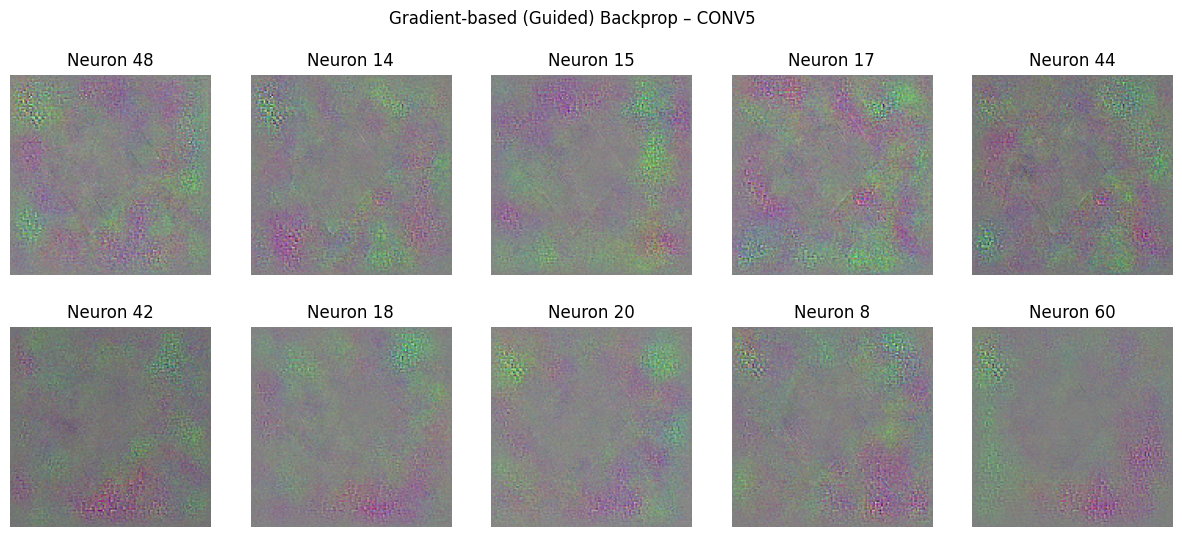

In [143]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))

for i, g in enumerate(grads):
    g = g.squeeze(0)
    g = g - g.min()
    g = g / (g.max() + 1e-8)

    plt.subplot(2, 5, i + 1)
    plt.imshow(g.permute(1, 2, 0))
    plt.axis("off")
    plt.title(f"Neuron {channels[i].item()}")

plt.suptitle("Gradient-based (Guided) Backprop – CONV5")
plt.show()

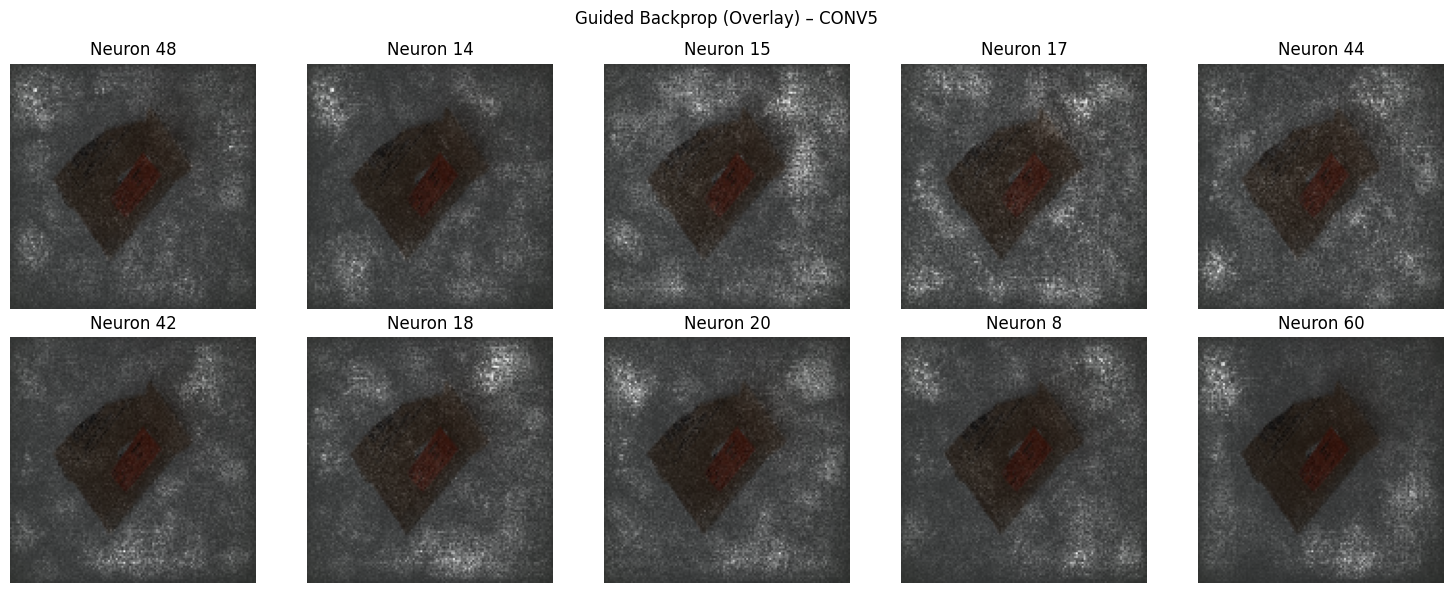

In [154]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))

orig = img.squeeze(0).permute(1, 2, 0).detach().cpu()
orig = orig - orig.min()
orig = orig / (orig.max() + 1e-8)

for i, grad in enumerate(grads):
    g = grad.squeeze(0)
    g = g.abs().mean(dim=0)
    g = (g - g.min()) / (g.max() + 1e-8)

    g_rgb = g.unsqueeze(-1).repeat(1, 1, 3)

    overlay = 0.2 * orig + 0.8 * g_rgb
    overlay = overlay.clamp(0, 1)

    plt.subplot(2, 5, i + 1)
    plt.imshow(overlay)
    plt.axis("off")
    plt.title(f"Neuron {channels[i].item()}")

plt.suptitle("Guided Backprop (Overlay) – CONV5")
plt.tight_layout()
plt.savefig("guided backprop (CONV5)")
plt.show()



<Figure size 640x480 with 0 Axes>